Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# 1. Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import warnings
from sklearn.metrics import make_scorer
import time

In [2]:
data = pd.read_csv('/datasets/autos.csv')

In [3]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


### Признаки:
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


***Удалим полные дубликаты***

In [5]:
data.drop_duplicates(inplace = True)

***Смортим количественные аномалии***

* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* **Power — мощность (л. с.)**
* Model — модель автомобиля
* **Kilometer — пробег (км)**
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* **NumberOfPictures** — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя
---
* **Price — цена (евро)**

In [6]:
list_column = ['Price', 'Power', 'Kilometer', 'RegistrationYear']

In [7]:
max(data['Kilometer'])

150000

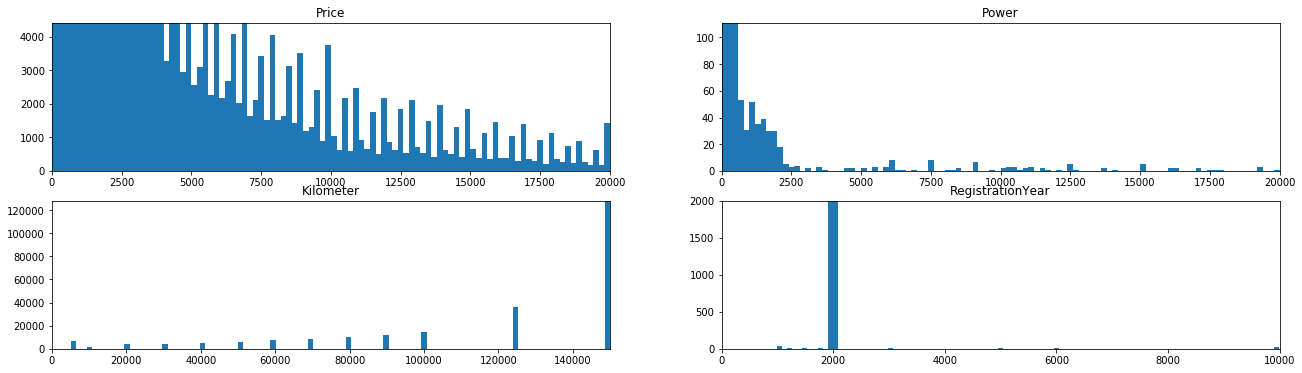

In [8]:
fig, axes = plt.subplots(2,2, figsize=(22,6))
fig.subplots_adjust(hspace = .2)
ax = axes.flatten()
for col in list_column:
    ax[list_column.index(col)].set_xlim(0, max(data[col] + 1))
    ax[list_column.index(col)].set_ylim(0, np.mean(data[col] + 1))
    ax[list_column.index(col)].set_title(col)
    ax[list_column.index(col)].hist(data[col], bins = 100, histtype = 'bar')

In [9]:
data = data.query('2020 > RegistrationYear | RegistrationYear > 1768')

**Удалим нулевые значения в поле Price и Power**

In [10]:
data.query('0 < Price < 20000', inplace = True)
data.query('0 < Power < 2000', inplace = True)

***Категориальные аномалии***

* DateCrawled — дата скачивания анкеты из базы
* **VehicleType — тип автомобильного кузова**
* RegistrationYear — год регистрации автомобиля
* **Gearbox — тип коробки передач**
* Power — мощность (л. с.)
* **Model — модель автомобиля**
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* **FuelType — тип топлива**
* **Brand — марка автомобиля**
* **NotRepaired — была машина в ремонте или нет**
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя
---
* Price — цена (евро)

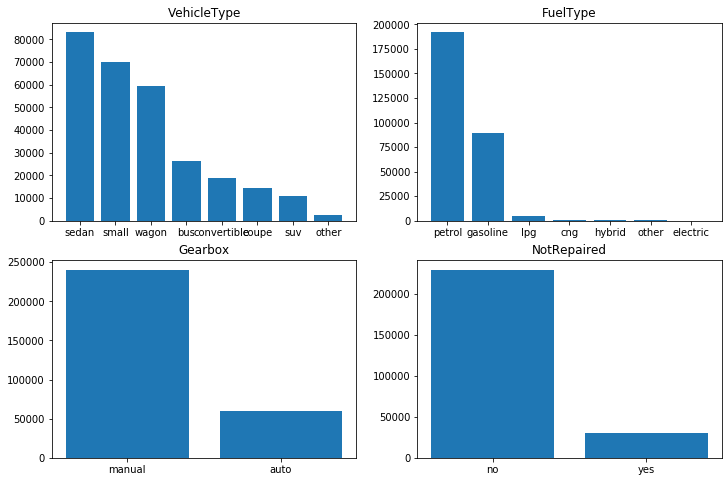

In [11]:
na_list = ['VehicleType', 'FuelType', 'Gearbox', 'NotRepaired']
fig, axes = plt.subplots(2,2, figsize=(12,8))
fig.subplots_adjust(hspace = .2)
ax = axes.flatten()
for na in na_list:
    tmp = data[data[na].notna()][na].value_counts()
    ax[na_list.index(na)].set_title(na)
    ax[na_list.index(na)].bar(height = tmp, x = tmp.index);

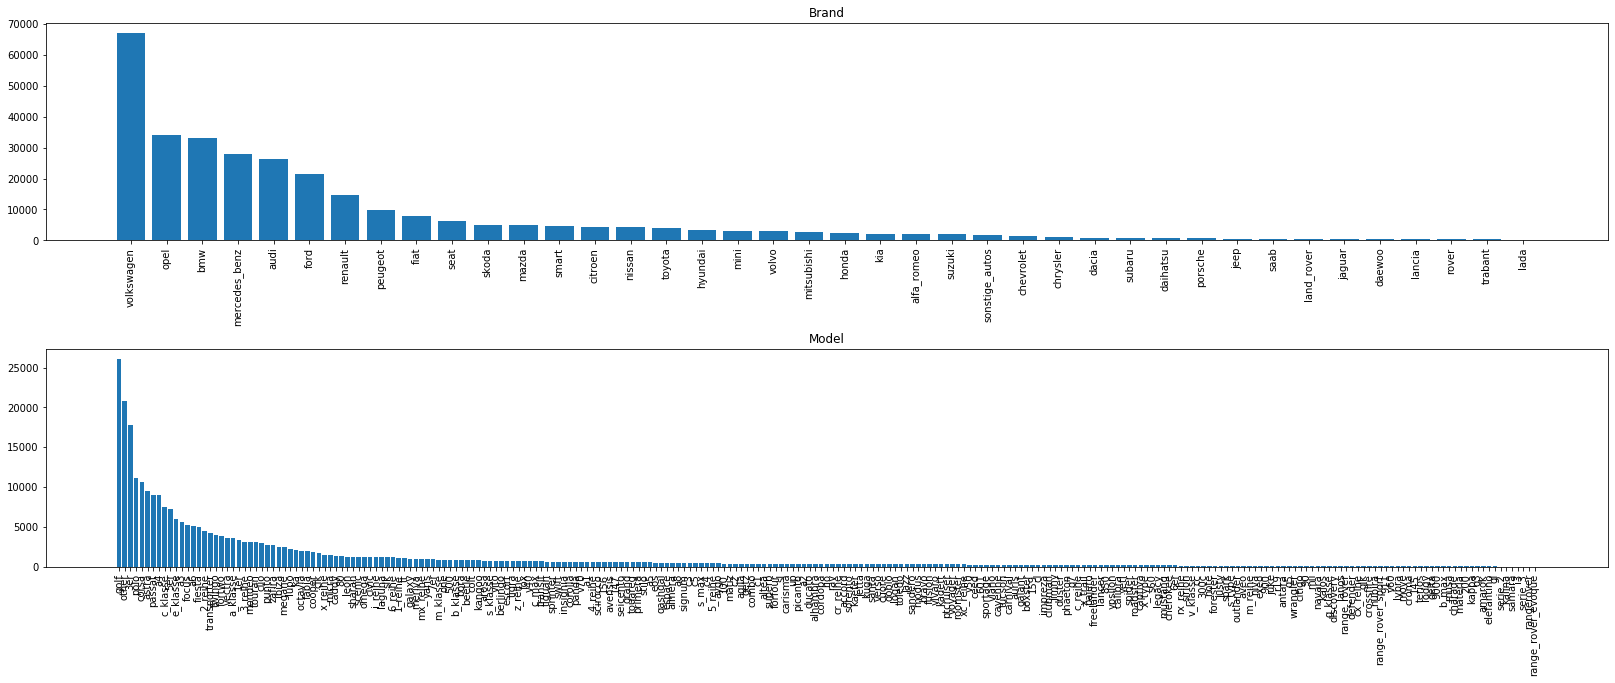

In [12]:
na_list = ['Brand', 'Model']
fig, ax = plt.subplots(2,1, figsize=(28,10))
fig.subplots_adjust(hspace = .5)
for na in na_list:
    tmp = data[data[na].notna()][na].value_counts()
    ax[na_list.index(na)].set_title(na)
    ax[na_list.index(na)].set_xticklabels(labels = tmp.index, rotation=90)
    ax[na_list.index(na)].bar(height = tmp, x = tmp.index, orientation = 'vertical');

#### Объекты с NaN:
* VehicleType -  тип автомобильного кузова
* Model - модель автомобиля
* FuelType — тип топлива
* Gearbox - коробка передач
* NotRepaired - была в ремонте или нет

In [13]:
mapper_model = data.groupby('Brand')['Model'].apply(lambda x: x.mode()).to_dict()
mapper_model = {(key[0]) : value for key, value in mapper_model.items()}

In [14]:
def input_model_nan (row):
    if row['Model'] != str:
        return mapper_model.get((row['Brand']), 'UNK')
    else: return row['Model']

In [15]:
#data['Model'] = data.apply(input_model_nan, axis = 1)

In [16]:
data['Model'].fillna('UNK', inplace = True)

---

In [17]:
mapper_veh = data.groupby(
    ['Brand', 'Model', 'RegistrationYear', 'RegistrationMonth']) \
                ['VehicleType'].apply(lambda x: x.mode()).to_dict()
mapper_model = {(key[:-1]) : value for key, value in mapper_model.items()}

In [18]:
def input_vehicle_nan (row):
    if row['VehicleType'] != str:
        return mapper_veh.get((row['Brand'], row['Model'], row['RegistrationYear'], 
                   row ['RegistrationMonth']), 'UNK')
    else: return row['VehicleType']

In [19]:
#data['VehicleType'] = data.apply(input_vehicle_nan, axis = 1)

In [20]:
data['VehicleType'].fillna('UNK', inplace = True)

**NaN в признаке тип топлива заполним топливом значением - UNK**

In [21]:
data['FuelType'].fillna('UNK', inplace = True)

**NaN в признаке коробка передач заполним значением - 'UNK', NaN в поле был автомобиль в ремонте или нет - 'UNK'**

In [22]:
data['Gearbox'].fillna('UNK', inplace = True)
data['NotRepaired'].fillna('UNK', inplace = True)

In [23]:
numeric_col = data.columns[data.dtypes.eq('int64')].to_list()
category_col = data.columns[data.dtypes.eq('object')].to_list()

***Уберем не информативные признаки***

In [24]:
data['NumberOfPictures'].value_counts()

0    306867
Name: NumberOfPictures, dtype: int64

In [25]:
del_num_col= \
['RegistrationMonth', 'NumberOfPictures', 'PostalCode']
numeric_col = [item for item in numeric_col if item not in del_num_col]

In [26]:
del_cat_col = ['DateCrawled', 'DateCreated', 'LastSeen']
category_col = [item for item in category_col if item not in del_cat_col]

In [27]:
data = data[numeric_col + category_col]

In [28]:
data[numeric_col].corr(method = 'spearman')

,Price,RegistrationYear,Power,Kilometer
Price,1.000000,0.607160,0.521834,-0.364794
RegistrationYear,0.607160,1.000000,0.163737,-0.347974
Power,0.521834,0.163737,1.000000,0.121198
Kilometer,-0.364794,-0.347974,0.121198,1.000000


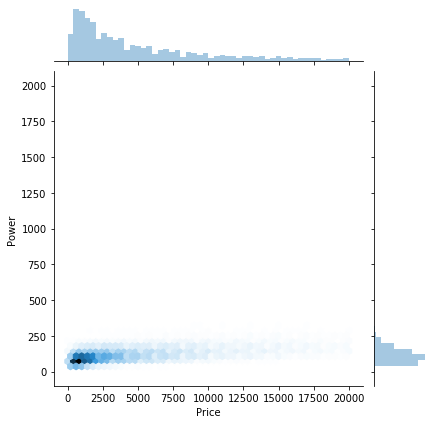

In [29]:
sns.jointplot(x=data['Price'], y=data['Power'], kind="hex");

***Сильная связь Цена/Мощность наблюдается до 2500 Евро. На цену автомобилей после этой отметки влияют и другие факторы*** 

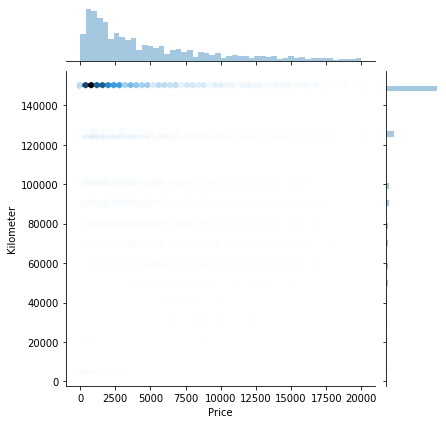

In [30]:
sns.jointplot(x=data['Price'], y=data['Kilometer'], kind="hex");

***Сильная отрицательная связь Цена/Пробег наблюдается тоже до 2500 Евро. На цену автомобилей после этой отметки влияют и другие факторы*** 

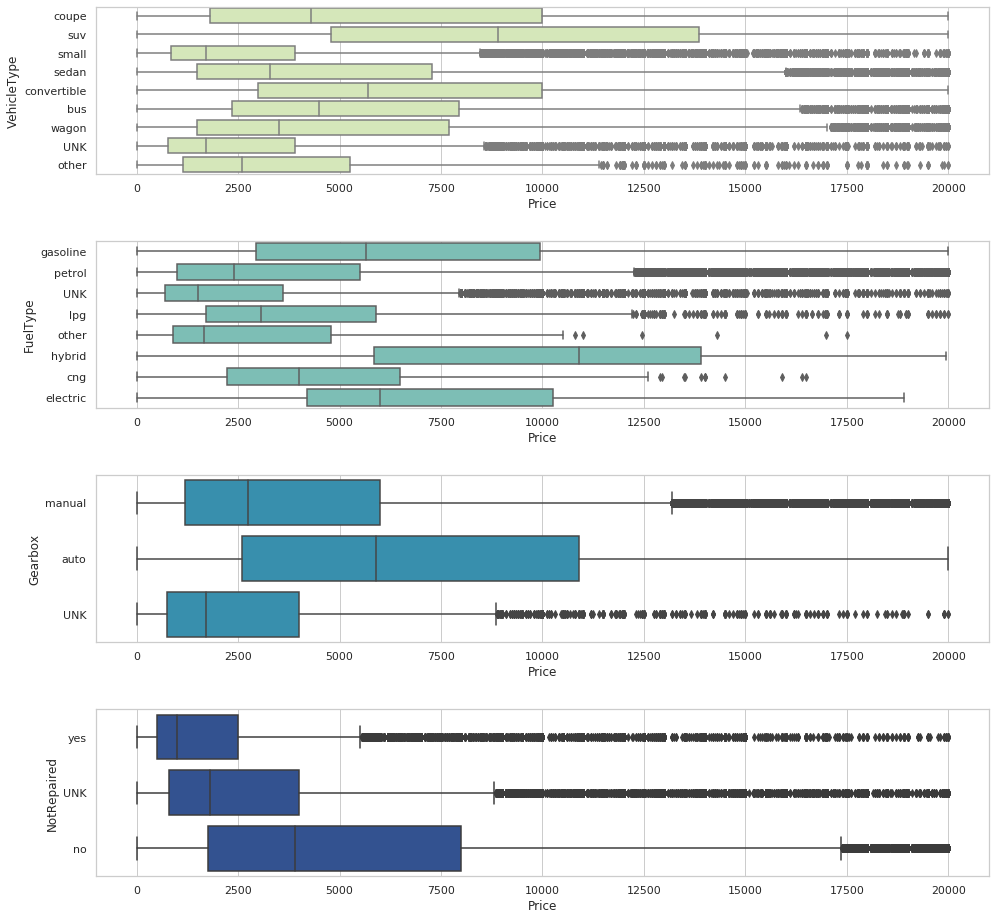

In [31]:
na_list = ['VehicleType', 'FuelType', 'Gearbox', 'NotRepaired']
current_palette = sns.color_palette('YlGnBu', n_colors=4)
sns.set(style="whitegrid")
fig, axes= plt.subplots(4, 1, figsize=(16, 16));
fig.subplots_adjust(hspace = .4)
ax = axes.flatten()

for name in na_list:
    tmp = data[[name,'Price']]
    sns.boxplot(x=tmp['Price'], y = name, data = tmp, color = current_palette[na_list.index(name)],
            orient="h", ax = ax[na_list.index(name)])

In [32]:
data[data['VehicleType'] == 'small']['Price'].describe()

count    70144.000000
mean      2886.579194
std       3050.643010
min          1.000000
25%        850.000000
50%       1700.000000
75%       3900.000000
max      19999.000000
Name: Price, dtype: float64

***Есть много больших значений в поле Price для авто в кузове small***

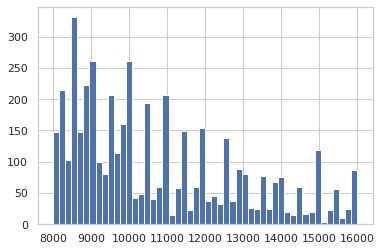

In [33]:
data[data['VehicleType'] == 'small']['Price'].hist(bins = 50, range = (8000, 16000));

***Для бустингов менял тип категориальных переменных на 'category', при обучении через GridSearchCV прироста RMSE не дало***

In [34]:
data.query('VehicleType == "small" & Price > 15000').tail(10)

,Price,RegistrationYear,Power,Kilometer,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired
348110,15299,2015,90,30000,small,manual,i_reihe,gasoline,hyundai,no
348650,16500,2013,179,50000,small,auto,ibiza,petrol,seat,no
348671,17890,2012,122,50000,small,auto,a1,petrol,audi,no
348743,16990,2014,182,20000,small,manual,UNK,petrol,ford,no
349882,19800,2012,184,10000,small,manual,cooper,petrol,mini,no
350637,16000,2013,98,30000,small,manual,one,petrol,mini,no
351864,16950,2014,86,20000,small,manual,a1,petrol,audi,no
353110,15999,2010,170,100000,small,manual,golf,gasoline,volkswagen,UNK
353473,16480,2012,211,50000,small,manual,cooper,petrol,mini,no
354178,19990,2014,185,10000,small,auto,a1,petrol,audi,no


In [35]:
#data[category_col] = data[category_col].astype('category')

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306867 entries, 1 to 354368
Data columns (total 10 columns):
Price               306867 non-null int64
RegistrationYear    306867 non-null int64
Power               306867 non-null int64
Kilometer           306867 non-null int64
VehicleType         306867 non-null object
Gearbox             306867 non-null object
Model               306867 non-null object
FuelType            306867 non-null object
Brand               306867 non-null object
NotRepaired         306867 non-null object
dtypes: int64(4), object(6)
memory usage: 35.8+ MB


# 2. Обучение моделей

***Делаем метрику RMSE***

In [37]:
def rmse_score(target, predictions):
    
    return (((target-predictions)**2).mean())**0.5    

In [38]:
rmse = make_scorer(rmse_score, greater_is_better=False)

In [39]:
target = data['Price']
features = data.drop(['Price'] , axis=1)
numeric_col.remove('Price')

In [40]:
features_train, features_valid, target_train, target_valid = (
        
    train_test_split(features, target, test_size=0.2, random_state=12345)
                                                                            )

***Создаем предобработчик для масштабирования числовых данных и кодирования категориальных. При бустинге OrdinalEncoder показал лучше метрику, чем встроенные в модели кодировщики***

In [41]:
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    
preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numeric_col),
            ('cat', categorical_transformer, category_col)])
 

***Создаем переменную, в которую будем записывать время обучения, предсказывания и показатели***

In [42]:
timer = []
scoring = []

### LinearRegression

***Создаем пайплайн предобратоботки и обучения Линейной Регрессии***   

In [43]:
pipe = make_pipeline(preprocessor, LinearRegression())

In [44]:
param_grid = {'linearregression__normalize': [True, False]}

grid = GridSearchCV(pipe, param_grid, cv=5, scoring = rmse) 

In [45]:
start = time.time()

grid.fit(features_train, target_train)

end = time.time()

timer.append(end - start)    

In [46]:
print("Лучшая модель:\n{}".format(grid.best_params_))

Лучшая модель:
{'linearregression__normalize': False}


In [47]:
start = time.time()

grid.score(features_valid, target_valid)

end = time.time()

timer.append(end - start)    

In [48]:
scoring.append(abs(grid.score(features_valid, target_valid)))
print("Правильность на тесте: {:.2f}". \
      format(scoring[-1]))

Правильность на тесте: 3005.23


---

### LightGBM

***Создаем пайплайн предобратоботки OrdinalEncoder и обучения LightGBM***   

In [49]:
categorical_transformer_oe = OrdinalEncoder()

In [50]:
    preprocessor_boost = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numeric_col),
            ('cat', categorical_transformer_oe, category_col)])

In [51]:
pipe_lgb = make_pipeline(preprocessor, LGBMRegressor(n_jobs = 1 ))

In [52]:
param_grid = {'lgbmregressor__n_estimators': [800], 
            'lgbmregressor__max_depth': [7,8],
            'lgbmregressor__num_leaves' : [70,80]}

grid_lgb = GridSearchCV(pipe_lgb, param_grid, cv=5, scoring = rmse) 

In [53]:
start = time.time()


grid_lgb.fit(features_train, target_train)

end = time.time()

timer.append(end - start)    

In [54]:
print("Лучшая модель:\n{}".format(grid_lgb.best_params_))

Лучшая модель:
{'lgbmregressor__max_depth': 8, 'lgbmregressor__n_estimators': 800, 'lgbmregressor__num_leaves': 80}


In [55]:
start = time.time()
grid_lgb.score(features_valid, target_valid)
end = time.time()
timer.append(end - start)    

In [56]:
scoring.append(abs(grid_lgb.score(features_valid, target_valid)))
print("Правильность на тестовом наборе: {:.2f}". \
      format(scoring[-1]))

Правильность на тестовом наборе: 1557.44


---

### XGBoost

***Создаем пайплайн предобратоботки OrdinalEncoder и обучения XGBoost. n_estimators и max_depth идентичны с LightGBM (для сравнения)***   

In [66]:
pipe_xgb = make_pipeline(preprocessor, XGBRegressor(
                                                    n_jobs =  1, 
                                                    objective = 'reg:squarederror',
                                                    n_estimators = 800,
                                                    max_depth = 8))

In [67]:
warnings.filterwarnings('ignore') 

param_grid = {'xgbregressor__colsample_bytree': [0.7, 0.8]}

grid_xgb = GridSearchCV(pipe_xgb, param_grid, cv=5, scoring = rmse) 

In [68]:
start = time.time()

grid_xgb.fit(features_train, target_train)

end = time.time()
timer.append(end - start)   

In [69]:
print("Лучшая модель:\n{}".format(grid_xgb.best_params_))

Лучшая модель:
{'xgbregressor__colsample_bytree': 0.7}


In [70]:
start = time.time()
grid_xgb.score(features_valid, target_valid)
end = time.time()
timer.append(end - start)   

In [71]:
scoring.append(abs(grid_xgb.score(features_valid, target_valid)))
print("Правильность на тестовом наборе: {:.2f}". \
      format(scoring[-1]))

Правильность на тестовом наборе: 1538.21


# 3. Анализ моделей

In [63]:
pd.DataFrame(data = [[timer[0],timer[2],timer[4]]], columns = ['LinearRegression_time_fit',
                                        'LightGBM_time_fit',
                                        'XGBoost_time_fit'])

,LinearRegression_time_fit,LightGBM_time_fit,XGBoost_time_fit
0,479.830478,430.031424,2079.726785


In [64]:
pd.DataFrame(data = [[timer[1],timer[3],timer[5]]], columns = ['LinearRegression_time_predict',
'LightGBM_time_predict',
'XGBoost_time_predict'])

,LinearRegression_time_predict,LightGBM_time_predict,XGBoost_time_predict
0,0.155873,6.472575,8.735037


***По времени обучения лидирует простая линейная регрессия, среди бустингов LightGBM, из-за малого расходования памяти в отличие от XGBoost***

In [65]:
pd.DataFrame([scoring], 
             columns = ['LinearRegression_score','LightGBM_score','XGBoost_time_score'])

,LinearRegression_score,LightGBM_score,XGBoost_time_score
0,3005.230256,1557.444507,1538.214042


***Качество предсказания лучше у XGBoost, почти вровень LightGBM (видимо из-за с работы узлами дерева - идет вертикально, не разростается  горизонтально по узлам дерева)***

***Заказчику важны:***
* качество предсказания;
* скорость предсказания;
* время обучения

***Исходя из требований заказчика предлагаю выбрать для определения стоимости автомобилей модель градиентного бустинга LightGBM*** 

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей